# Problème de régression - GUIMONT Mathieu  CLEREMPUY Gabriel
On dispose d'un fichier "CarPrice_Assignment.csv" qui contient 26 colonnes et 205 lignes, correspondant à des caractéristiques de voitures (https://www.kaggle.com/datasets/hellbuoy/car-price-prediction/code).


On va chercher à estimer le prix de la voiture en fonction des autres paramètres, quantitatifs et qualitatifs.

Paramètres quantitatifs: carlength, carwidth, carheight, curbweight, wheelbase, boreratio,stroke, compressionratio,horsepower,peakrpm, citympg,highwaympg

Paramètres qualitatifs: symboling, CarName, fueltype, aspiration, doornumber, carbody, drivewheel, enginelocation, enginetype, cylindernumber, enginesize ,fuelsystem




# Import des librairies utiles


In [166]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


#Test de plusieurs modèles
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Import des données

In [115]:
filename = "CarPrice_Assignment.csv"
data_full = pd.read_csv(filename, header=0)
print(data_full.shape)
data_full.head()

(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Prétraitement des données
Pour utiliser nos variables catégorielles dans nos modèles, nous allons devoir encoder nos variables.
Le OneHotEncoder est l'encodeur le plus adapté à celà pour nos variables qui ne présentent pas de hiérarchie entre leurs différentes valeurs possibles (tel que 'petit', 'moyen', 'grand').

In [117]:
X_cat = data_full.iloc[:, [1,2,3,4,5,6,7,8,14,15,17]]  # Sélection des caractéristiques quantitatives (en supposant que la première et dernière colonnes sont catégorielles)
X_quant=data_full.iloc[:, [9,10,11,12,13,16,18,19,20,21,22,23,24]]
y = data_full.iloc[: , 25 ] #La colonne du prix

quant_columns=[9,10,11,12,13,16,18,19,20,21,22,23,24]

encoder = OneHotEncoder()
X_cat_encoded = pd.DataFrame(encoder.fit_transform(X_cat).toarray(), columns=encoder.get_feature_names_out(X_cat.columns))
X_processed = pd.concat([X_cat_encoded, pd.DataFrame(X_quant, columns=data_full.columns[quant_columns])], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.33, random_state=0)
X_processed

,symboling_-2,symboling_-1,symboling_0,symboling_1,symboling_2,symboling_3,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,...,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.5,2952,141,3.78,3.15,9.5,114,5400,23,28
201,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.5,3049,141,3.78,3.15,8.7,160,5300,19,25
202,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.5,3012,173,3.58,2.87,8.8,134,5500,18,23
203,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.5,3217,145,3.01,3.40,23.0,106,4800,26,27


In [131]:
#Permet d'afficher les poids pour chaque variable après entraînement du modèle
def affichage_poids(model):
    # Obtention des poids
    feature_weights = model.coef_

    # Create a dictionary to pair feature names with their weights
    feature_weights_dict = dict(zip(X_processed.columns.to_list(), feature_weights))
    # Assuming you've already created the feature_weights_dict
    feature_weights_df = pd.DataFrame(feature_weights_dict.items(), columns=['Variable', 'Poids'])

    transposed_df = feature_weights_df.transpose()

    # Display the DataFrame
    print('\n', transposed_df.to_string())

# Test de plusieurs modèles
On commence par un modèle très simple qui va servir de point de comparaison par rapport aux autres modèles.
Le modèle LinearRegression est un modèle simple qui va chercher à établir une relation linéaire entre les variables explicatives et la variable cible. Le modèle cherche à ajuster ces coefficients de manière à minimiser la somme des carrés des différences entre les valeurs prédites et les valeurs réelles des données d'entraînement. Cependant, il suppose une relation linéaire entre les variables explicatives et la variable cible, ce qui peut ne pas être adapté à des relations plus complexes ou non linéaires entre les variables.

Pour l'optimisation des hyperparamètres des modèles, on utilisera à chaque fois optuna qui est une bibliothèque permettant de tester la performance d'un modèle en fonction de plusieurs sets d'hyperparamètres déterminés grâce à des algorithmes commme TPE (Tree-structured Parzen Estimator).

On choisira la "Mean Squared Error" comme métrique pour mesurer la performance d'un modèle car on cherche à évaluer les erreurs individuelles de prédiction


In [132]:
# Fonction objectif pour Optuna utilisant la Mean Squared Error (MSE)
def objective(trial):
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    positive = trial.suggest_categorical('positive', [True, False])

    model = LinearRegression(fit_intercept=fit_intercept, positive=positive)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Création et exécution de l'étude Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Obtention des meilleurs paramètres et calcul du MSE et du R2 avec les paramètres optimisés
best_params = study.best_params
best_model = LinearRegression(**best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
mse_reglin= mean_squared_error(y_test, y_pred_best)
r2_reglin = r2_score(y_test, y_pred_best)

print('\n')
print(f"Meilleurs hyperparamètres: {best_params}")
print(f"MSE optimisé de LinearRegression: {mse_reglin}")
print(f"R2 correspondant: {r2_reglin}")
affichage_poids(best_model)

[I 2024-01-08 16:59:27,034] A new study created in memory with name: no-name-8b69e00e-9e90-491a-91d3-4e9ed6d31d9a
[I 2024-01-08 16:59:27,109] Trial 0 finished with value: 473360180.5052456 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 0 with value: 473360180.5052456.
[I 2024-01-08 16:59:27,187] Trial 1 finished with value: 453611394.76300454 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 1 with value: 453611394.76300454.
[I 2024-01-08 16:59:27,235] Trial 2 finished with value: 300477196.5850369 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 2 with value: 300477196.5850369.
[I 2024-01-08 16:59:27,341] Trial 3 finished with value: 453611394.76300454 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 2 with value: 300477196.5850369.


[I 2024-01-08 16:59:27,440] Trial 4 finished with value: 453611394.76300454 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 2 with value: 300477196.5850369.
[I 2024-01-08 16:59:27,495] Trial 5 finished with value: 300477196.5850369 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 2 with value: 300477196.5850369.
[I 2024-01-08 16:59:27,516] Trial 6 finished with value: 26156212.014953274 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 26156212.014953274.
[I 2024-01-08 16:59:27,546] Trial 7 finished with value: 26156212.014953274 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 26156212.014953274.
[I 2024-01-08 16:59:27,583] Trial 8 finished with value: 473360180.5052456 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 26156212.014953274.
[I 2024-01-08 16:59:27,623] Trial 9 finished with value: 453611394.76300454 and para



Meilleurs hyperparamètres: {'fit_intercept': False, 'positive': True}
MSE optimisé de LinearRegression: 26156212.014953274
R2 correspondant: 0.5759401113614121

                    0             1            2            3            4            5                     6                                 7                           8                            9                    10                  11                 12                 13                           14                15                16              17              18              19              20              21                     22                                23                             24                                25                               26                                       27                     28                     29                        30                             31                           32                           33                       34                          35  

# Lasso
Lasso possède la capacité de pénaliser les coefficients des variables moins importantes en les conduisant vers zéro. Cela permet une sélection automatique des caractéristiques en éliminant celles qui ont peu d'impact sur la prédiction. Le modèle devient plus simple, celà peut aider à éviter l'overfiting. 
De plus, en présence de multicollinéarités, Lasso a tendance à choisir une variable parmi les variables fortement corrélées et à pénaliser les autres, ce qui peut améliorer la stabilité des prédictions.
Dans notre cas, nous avons beaucoup de variables qui sont corrélées entre elles. Et il est fort probable que certaines de nos variables soient moins significatives que d'autres dans la prédiction du prix. Par conséquent la régularisation Lasso est pertinente.

In [134]:
alpha_values = []
mse_scores = []

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1000, log=True)  # dans un espace logarithmique
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    # enregistrement de alpha et du mse correspondant
    alpha_values.append(alpha)
    mse_scores.append(mse)

    return mse

# Lancement de l'optimisation Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Récupération du meilleur alpha d'Optuna
best_alpha = study.best_params['alpha']

# TEntraînement du modèle avec le meilleur alpha
best_lasso = Lasso(alpha=best_alpha)
best_lasso.fit(X_train, y_train)
y_pred = best_lasso.predict(X_test)

# Calcul des métriques
mse_lasso = mean_squared_error(y_test, y_pred)
r2_lasso = r2_score(y_test, y_pred)

print('\n')
print(f"Best Alpha (Lasso) from Optuna: {best_alpha}")
print(f"Mean Squared Error with Lasso (using best alpha): {mse_lasso}")
print(f"r2 with Lasso (using best alpha): {r2_lasso}")

affichage_poids(best_lasso)

[I 2024-01-08 17:00:23,757] A new study created in memory with name: no-name-a851bace-e21a-4611-baea-12591e0976d1
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e+07, tolerance: 8.812e+05
  model = cd_fast.enet_coordinate_descent(
[I 2024-01-08 17:00:23,848] Trial 0 finished with value: 34336989.42841562 and parameters: {'alpha': 0.08652290187660243}. Best is trial 0 with value: 34336989.42841562.
[I 2024-01-08 17:00:23,869] Trial 1 finished with value: 8715931.829242714 and parameters: {'alpha': 35.15082984826603}. Best is trial 1 with value: 8715931.829242714.
[I 2024-01-08 17:00:23,893] Trial 2 finished with value: 12049921.303776145 and parameters: {'alp



Best Alpha (Lasso) from Optuna: 40.700753668423864
Mean Squared Error with Lasso (using best alpha): 8648805.4638422
r2 with Lasso (using best alpha): 0.8597804804550064

                    0             1            2            3            4            5                     6                                 7                           8                            9                    10                  11                 12                 13                           14                15                16              17              18              19              20              21                     22                                23                             24                                25                               26                                       27                     28                     29                        30                             31                           32                           33                       34                    

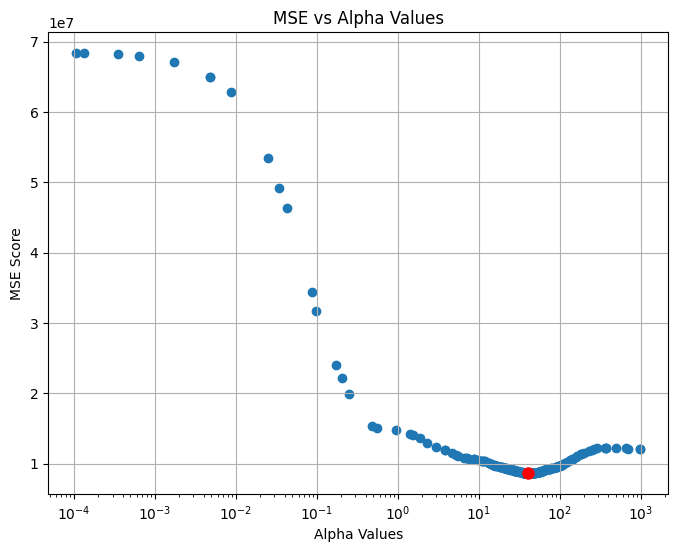

In [135]:
# Plotting the R2 scores against alpha values
plt.figure(figsize=(8, 6))
plt.scatter(alpha_values, mse_scores, marker='o')
plt.plot(best_alpha, mse_lasso, marker='o', markersize=8, color='red')  # Point le plus optimisé (toujours montré en rouge)
plt.title('MSE vs Alpha Values')
plt.xlabel('Alpha Values')
plt.ylabel('MSE Score')
plt.xscale('log')  # Puisque alpha est dans un espace logarithmique
plt.grid(True)
plt.show()

# Ridge
Ridge utilise une pénalité L2 dans sa fonction de coût, par opposition à la pénalité L1 utilisée par Lasso. Cette pénalité favorise des coefficients plus petits sans les annuler complètement, contrairement à Lasso. Ridge maintient donc chaque variable dans le modèle.
Ridge utilise donc une autre approche de régularisation.


[I 2024-01-08 17:01:43,668] A new study created in memory with name: no-name-e9eaf8dd-fcfc-4a98-b2fd-4d2c689598c4
[I 2024-01-08 17:01:43,715] Trial 0 finished with value: 9954550.425541172 and parameters: {'alpha': 4.665841772033686}. Best is trial 0 with value: 9954550.425541172.
[I 2024-01-08 17:01:43,730] Trial 1 finished with value: 180084801.46980357 and parameters: {'alpha': 0.0001503211996554319}. Best is trial 0 with value: 9954550.425541172.


[I 2024-01-08 17:01:43,747] Trial 2 finished with value: 11629621.72302855 and parameters: {'alpha': 214.10252892782609}. Best is trial 0 with value: 9954550.425541172.
[I 2024-01-08 17:01:43,776] Trial 3 finished with value: 54870891.99234842 and parameters: {'alpha': 0.0006689664812140052}. Best is trial 0 with value: 9954550.425541172.
[I 2024-01-08 17:01:43,791] Trial 4 finished with value: 11599437.064947523 and parameters: {'alpha': 175.87914812852296}. Best is trial 0 with value: 9954550.425541172.
[I 2024-01-08 17:01:43,816] Trial 5 finished with value: 10228987.727501461 and parameters: {'alpha': 7.8401050921024575}. Best is trial 0 with value: 9954550.425541172.
[I 2024-01-08 17:01:43,831] Trial 6 finished with value: 18812595.620158054 and parameters: {'alpha': 0.003680188263901513}. Best is trial 0 with value: 9954550.425541172.
[I 2024-01-08 17:01:43,868] Trial 7 finished with value: 10733910.812267108 and parameters: {'alpha': 17.837567407157962}. Best is trial 0 with val



Meilleur Alpha pour Ridge (Optuna) : 1.9046853536569652
Erreur quadratique moyenne avec Ridge (utilisant le meilleur alpha d'Optuna) : 9745363.961285017
r2 avec Ridge (utilisant le meilleur alpha d'Optuna) : 0.8420024293348574

                    0             1            2            3            4            5                     6                                 7                           8                            9                    10                  11                 12                 13                           14                15                16              17              18              19              20              21                     22                                23                             24                                25                               26                                       27                     28                     29                        30                             31                           32                 

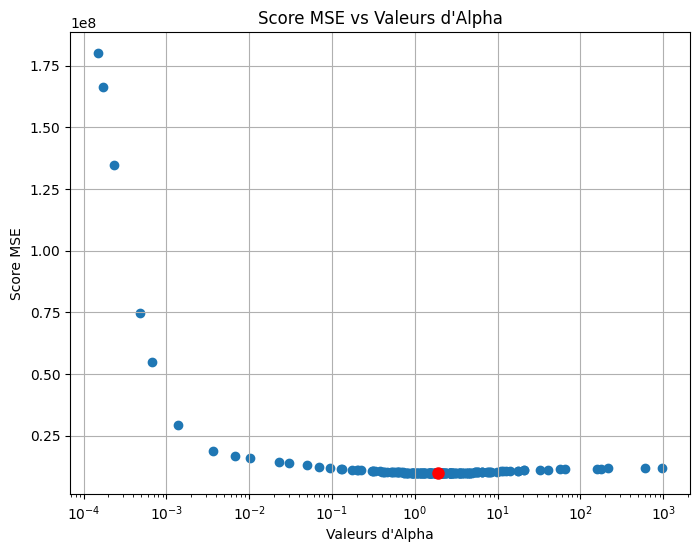

In [136]:
alpha_values = []
mse_scores = []

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1000, log=True)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Stocke l'alpha et le score MSE correspondant
    alpha_values.append(alpha)
    mse_scores.append(mse)
    return mse

# Création d'une étude Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Obtient le meilleur alpha de Optuna
best_alpha = study.best_params['alpha']

# Entraîne le modèle Ridge en utilisant le meilleur alpha
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_train, y_train)
y_pred = best_ridge.predict(X_test)

# Calcul des métriques
mse_ridge = mean_squared_error(y_test, y_pred)
r2_ridge = r2_score(y_test, y_pred)

print('\n')
print(f"Meilleur Alpha pour Ridge (Optuna) : {best_alpha}")
print(f"Erreur quadratique moyenne avec Ridge (utilisant le meilleur alpha d'Optuna) : {mse_ridge}")
print(f"r2 avec Ridge (utilisant le meilleur alpha d'Optuna) : {r2_ridge}")

affichage_poids(best_ridge)

# Trace les scores MSE en fonction des valeurs d'alpha
plt.figure(figsize=(8, 6))
plt.scatter(alpha_values, mse_scores, marker='o')
plt.plot(best_alpha, mse_ridge, marker='o', markersize=8, color='red')  # Point le plus optimisé
plt.title('Score MSE vs Valeurs d\'Alpha')
plt.xlabel('Valeurs d\'Alpha')
plt.ylabel('Score MSE')
plt.xscale('log')  # Puisque alpha est dans un espace logarithmique
plt.grid(True)
plt.show()

# ElasticNet
ElasticNet utilise à la fois les pénalités L1 (comme Lasso) et L2 (comme Ridge) dans sa fonction de coût.
Pouvant opter pour une stratégie hybride, ElasticNet est donc supposé être plus précis et pourrait générer des meilleures prédictions.


In [137]:
# Réinitialise les listes pour ElasticNet
alpha_values_en = []
r2_scores_en = []
l1_ratio_values_en = []

def objective_en(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1000, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)

    en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    en.fit(X_train, y_train)
    y_pred = en.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Stocke alpha et le score MSE correspondant
    alpha_values_en.append(alpha)
    l1_ratio_values_en.append(l1_ratio)
    r2_scores_en.append(r2)
    return mse

# Crée une étude Optuna pour ElasticNet
study_en = optuna.create_study(direction='minimize')
study_en.optimize(objective_en, n_trials=400)

# Obtient le meilleur alpha et l1_ratio de Optuna
best_alpha_en = study_en.best_params['alpha']
best_l1_ratio_en = study_en.best_params['l1_ratio']

# Entraîne le modèle ElasticNet en utilisant les meilleurs hyperparamètres
best_en = ElasticNet(alpha=best_alpha_en, l1_ratio=best_l1_ratio_en)
best_en.fit(X_train, y_train)
y_pred_en = best_en.predict(X_test)

# Calcule les métriques pour ElasticNet
mse_en = mean_squared_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)

print('\n')
print(f"Meilleur Alpha pour ElasticNet (Optuna) : {best_alpha_en}")
print(f"Meilleur L1 Ratio pour ElasticNet (Optuna) : {best_l1_ratio_en}")
print(f"Erreur quadratique moyenne avec ElasticNet (utilisant les meilleurs hyperparamètres d'Optuna) : {mse_en}")
print(f"r2 avec ElasticNet (utilisant les meilleurs hyperparamètres d'Optuna) : {r2_en}")

affichage_poids(best_lasso)

[I 2024-01-08 17:02:40,763] A new study created in memory with name: no-name-1f377d5b-9db8-41f8-b1da-311eb1dac76b
[I 2024-01-08 17:02:40,798] Trial 0 finished with value: 11885352.54302972 and parameters: {'alpha': 137.78530693371363, 'l1_ratio': 0.8370376137074338}. Best is trial 0 with value: 11885352.54302972.


C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.148e+07, tolerance: 8.812e+05
  model = cd_fast.enet_coordinate_descent(
[I 2024-01-08 17:02:40,903] Trial 1 finished with value: 10675458.936381642 and parameters: {'alpha': 0.010090278500506289, 'l1_ratio': 0.7897984673110608}. Best is trial 1 with value: 10675458.936381642.
[I 2024-01-08 17:02:40,979] Trial 2 finished with value: 9771093.967120782 and parameters: {'alpha': 0.027165887037114613, 'l1_ratio': 0.3011028345840959}. Best is trial 2 with value: 9771093.967120782.
[I 2024-01-08 17:02:41,036] Trial 3 finished with value: 11857052.797669932 and parameters: {'alpha': 24.285636124917225, 'l1_ratio': 0.03511



Meilleur Alpha pour ElasticNet (Optuna) : 0.07608429602697854
Meilleur L1 Ratio pour ElasticNet (Optuna) : 0.8193821330601591
Erreur quadratique moyenne avec ElasticNet (utilisant les meilleurs hyperparamètres d'Optuna) : 9743965.326113414
r2 avec ElasticNet (utilisant les meilleurs hyperparamètres d'Optuna) : 0.8420251048306355

                    0             1            2            3            4            5                     6                                 7                           8                            9                    10                  11                 12                 13                           14                15                16              17              18              19              20              21                     22                                23                             24                                25                               26                                       27                     28                     2

Le L1_ratio optimal de ElasticNet est proche de 1 donc ElasticNet opère majoritairement comme Lasso et les meilleures performances sont d'ailleurs obtenues par Lasso.
Donc il doit il y avoir un faible nombre de paramètres significatifs. Lasso a réduit à 0 les poids des autres ce qui a produit une meilleure performance que Ridge.

C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.776e+07, tolerance: 8.812e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.798e+07, tolerance: 8.812e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalC

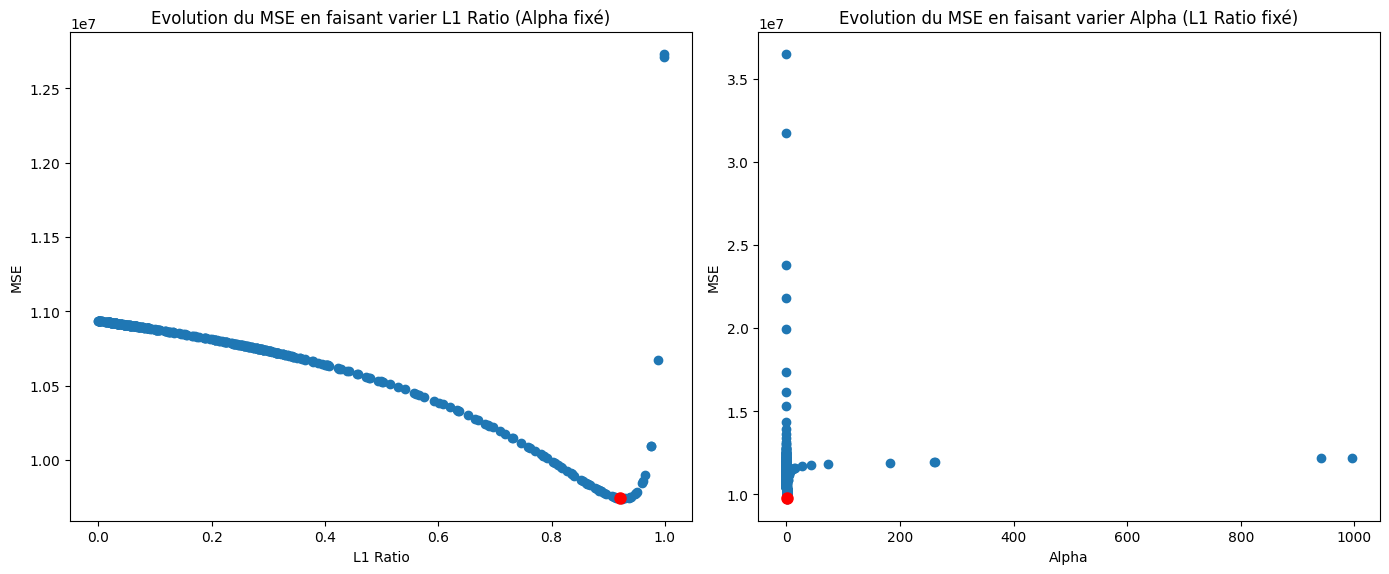

In [37]:
# Créer des sous-graphiques pour les tracés côte à côte
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Fixer alpha à best_alpha, faire varier l1_ratio
mse_scores_fixed_alpha = []
for i in range(len(l1_ratio_values_en)):
    alpha_fixed_model_en = ElasticNet(alpha=best_alpha_en, l1_ratio=l1_ratio_values_en[i])
    alpha_fixed_model_en.fit(X_train, y_train)
    y_pred_en = alpha_fixed_model_en.predict(X_test)
    mse_dot = mean_squared_error(y_test, y_pred_en)
    mse_scores_fixed_alpha.append(mse_dot)

axs[0].scatter(l1_ratio_values_en, mse_scores_fixed_alpha, marker='o')
axs[0].plot(best_l1_ratio_en, mse_en, marker='o', markersize=8, color='red')  # Point représentant le meilleur alpha
axs[0].set_title('Evolution du MSE en faisant varier L1 Ratio (Alpha fixé)')
axs[0].set_xlabel('L1 Ratio')
axs[0].set_ylabel('MSE')

# Fixer L1_ratio à best_l1_ratio, faire varier alpha
mse_scores_fixed_l1_ratio = []
for i in range(len(alpha_values_en)):
    l1_ratio_fixed_model_en = ElasticNet(alpha=alpha_values_en[i], l1_ratio=best_l1_ratio_en)
    l1_ratio_fixed_model_en.fit(X_train, y_train)
    y_pred_en = l1_ratio_fixed_model_en.predict(X_test)
    mse_dot = mean_squared_error(y_test, y_pred_en)
    mse_scores_fixed_l1_ratio.append(mse_dot)

axs[1].scatter(alpha_values_en, mse_scores_fixed_l1_ratio, marker='o')
axs[1].set_title('Evolution du MSE en faisant varier Alpha (L1 Ratio fixé)')
axs[1].plot(best_alpha_en, mse_en, marker='o', markersize=8, color='red')  # Point représentant le meilleur L1 ratio
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('MSE')

plt.tight_layout()
plt.show()

    

# RandomForestRegressor
RandomForestRegressor peut étudier des relations non-linéaires entre les variables explicatives et la variable à prédire. Il est également moins influencé par les points aberrants et peut prendre en compte les intéractions entre les variables. 

Avec une bonne optimisation de ses hyperparamètres, le modèle devrait donc avoir de meilleurs résultats que les méthodes de régularisation.

In [151]:
# On initialise avec aucune valeur d'hyperparamètres
r2_scores_rf = {'n_estimators': [], 'max_depth': [], 'min_samples_split': [], 'min_samples_leaf': []}
mse_scores_rf = {'n_estimators': [], 'max_depth': [], 'min_samples_split': [], 'min_samples_leaf': []}
hyperparameters = {'n_estimators': [], 'max_depth': [], 'min_samples_split': [], 'min_samples_leaf': []}

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }
    
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Stocke les scores R2 et MSE pour chaque hyperparamètre
    for param_name, param_value in params.items():
        r2_scores_rf[param_name].append(r2)
        hyperparameters[param_name].append(param_value)
        mse_scores_rf[param_name].append(mse)
    
    return mse  # Optuna cherche à minimiser, donc utilise la MSE


# Crée une étude Optuna pour RandomForestRegressor
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=200)

# Obtient l'indice du meilleur score MSE à travers tous les hyperparamètres
best_mse_index = np.argmin([min(mses) for mses in mse_scores_rf.values()])

# Extrait les meilleurs hyperparamètres
best_hyperparameters = {param_name: values[best_mse_index] for param_name, values in hyperparameters.items()}

print('\n')
print("Meilleurs hyperparamètres:")
for param_name, param_value in best_hyperparameters.items():
    print(f"{param_name}: {param_value}")

best_mse_RandomForest = min([min(mses) for mses in mse_scores_rf.values()])
r2_RandomForest = max([max(scores) for scores in r2_scores_rf.values()])
print(f"Meilleure MSE: {best_mse_RandomForest:.4f}")
print(f"R2 correspondant: {r2_RandomForest:.4f}")

#Affichage des poids
best_RandomForest= RandomForestRegressor(**study_rf.best_params)
best_RandomForest.fit(X_train, y_train)

# Obtention du poids des variables
feature_importance = best_RandomForest.feature_importances_

# Création d'un DataFrame pour afficher les importances des variables
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Poids': feature_importance})
importance_df = importance_df.sort_values('Poids', ascending=False)

print("\n Importance des variables :")
importance=importance_df.T
print(importance.to_string())

[I 2024-01-08 18:24:22,555] A new study created in memory with name: no-name-01cf30ff-71ba-40e1-841e-c8624fa19ca7
[I 2024-01-08 18:24:22,673] Trial 0 finished with value: 7273612.352649658 and parameters: {'n_estimators': 21, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 0 with value: 7273612.352649658.
[I 2024-01-08 18:24:23,150] Trial 1 finished with value: 6683528.154639624 and parameters: {'n_estimators': 83, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 6683528.154639624.
[I 2024-01-08 18:24:23,330] Trial 2 finished with value: 6919046.752718257 and parameters: {'n_estimators': 36, 'max_depth': 24, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 6683528.154639624.
[I 2024-01-08 18:24:23,612] Trial 3 finished with value: 7184885.30843728 and parameters: {'n_estimators': 73, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 4}. Best is trial 1 with value: 6683528.15



Meilleurs hyperparamètres:
n_estimators: 21
max_depth: 3
min_samples_split: 12
min_samples_leaf: 5
Meilleure MSE: 5145555.3395
R2 correspondant: 0.9166

 Importance des variables :
                 196         195       193         200             166         203        192        191        194       202               199       201       198                 179           154             21         197            162                  90                   178                  177              153                  10              186          2               19                156                  149             172             18           3               165              188                55              155                  144          5                 16               160                   176                  91                      131                161                147              174              184                            24                 60                       

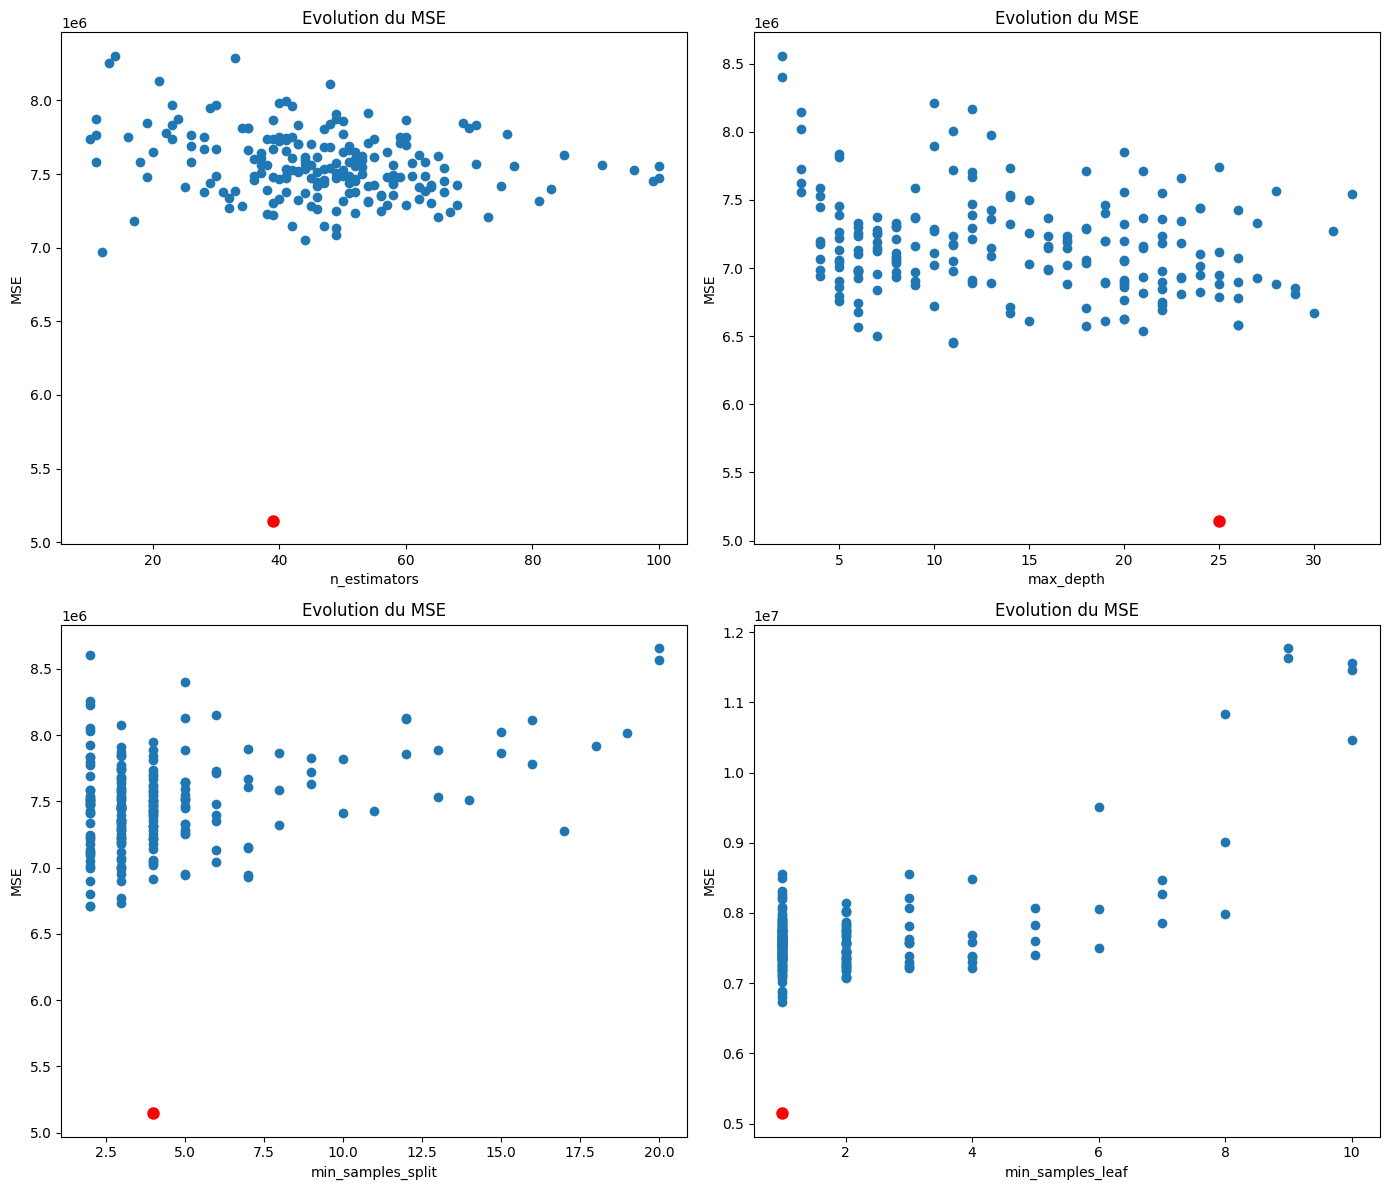

In [167]:
#AFFICHAGE (ne fonctionne pas)
best_n_estimators_RandomForest = best_hyperparameters['n_estimators']
best_max_depth_RandomForest = best_hyperparameters['max_depth']
best_min_samples_RandomForest = best_hyperparameters['min_samples_split']
best_min_samples_leaf_RandomForest = best_hyperparameters['min_samples_leaf']


fig, axs = plt.subplots(2, 2, figsize=(14, 12))


def plot_RandomForest(axs_row, axs_col, name_hyperparameter):
    mse_scores_fixed_parameter = []
    for i in range(len(hyperparameters[name_hyperparameter])):
        if name_hyperparameter=='n_estimators':
            fixed_n_estimators_model_RandomForest= RandomForestRegressor(n_estimators=hyperparameters[name_hyperparameter][i],
                                                                        max_depth=best_max_depth_RandomForest,
                                                                        min_samples_split=best_min_samples_RandomForest,
                                                                        min_samples_leaf=best_min_samples_leaf_RandomForest)        
        if name_hyperparameter=='max_depth':
            fixed_n_estimators_model_RandomForest= RandomForestRegressor(n_estimators=best_n_estimators_RandomForest,
                                                                        max_depth=hyperparameters[name_hyperparameter][i],
                                                                        min_samples_split=best_min_samples_RandomForest,
                                                                        min_samples_leaf=best_min_samples_leaf_RandomForest)
        if name_hyperparameter=='min_samples_split':
            fixed_n_estimators_model_RandomForest= RandomForestRegressor(n_estimators=best_n_estimators_RandomForest,
                                                                        max_depth=best_max_depth_RandomForest,
                                                                        min_samples_split=hyperparameters[name_hyperparameter][i],
                                                                        min_samples_leaf=best_min_samples_leaf_RandomForest)
        if name_hyperparameter=='min_samples_leaf':
            fixed_n_estimators_model_RandomForest= RandomForestRegressor(n_estimators=best_n_estimators_RandomForest,
                                                                        max_depth=best_max_depth_RandomForest,
                                                                        min_samples_split=best_min_samples_RandomForest,
                                                                        min_samples_leaf=hyperparameters[name_hyperparameter][i])


        fixed_n_estimators_model_RandomForest.fit(X_train, y_train)
        y_pred_en = fixed_n_estimators_model_RandomForest.predict(X_test)
        mse_dot = mean_squared_error(y_test, y_pred_en)
        mse_scores_fixed_parameter.append(mse_dot)

    axs[axs_row, axs_col].scatter(hyperparameters[name_hyperparameter], mse_scores_fixed_parameter, marker='o')
    axs[axs_row, axs_col].plot(study_rf.best_params[name_hyperparameter], best_mse_RandomForest, marker='o', markersize=8, color='red')
    axs[axs_row, axs_col].set_title('Evolution du MSE')
    axs[axs_row, axs_col].set_xlabel(name_hyperparameter)
    axs[axs_row, axs_col].set_ylabel('MSE')

plot_RandomForest(0, 0, 'n_estimators')
plot_RandomForest(0, 1, 'max_depth')    
plot_RandomForest(1, 0, 'min_samples_split')
plot_RandomForest(1, 1, 'min_samples_leaf')

plt.tight_layout()
plt.show()

# GradientBoostingRegressor
GradientBoostingRegressor construit les arbres de manière séquentielle: chaque arbre corrige les erreurs commises par le précédent. Il se concentre sur les différences entre les valeurs prédites et réelles des arbres précédents. 
Ce modèle possède plusieurs qualités des précèdents modèles: robustesse aux données aberrantes, gestion de la sélection de variables, gestion de la non-linéarité.

On s'attend donc à avoir de meilleurs résultats qu'avec RandomForestRegressor.

In [162]:
# Définition de la fonction objectif pour Optuna
def objectif(trial):
    # Définition de l'espace de recherche des hyperparamètres
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'learning_rate': trial.suggest_int('learning_rate', 0, 1000),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_impurity_decrease': trial.suggest_int('min_impurity_decrease', 0, 1000),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    # Création du modèle avec les hyperparamètres choisis
    model = GradientBoostingRegressor(**params)

    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédictions sur l'ensemble de validation
    y_pred = model.predict(X_test)

    # Retourne la MSE négative car Optuna cherche à minimiser l'objectif
    return mean_squared_error(y_test, y_pred)

# Création d'une étude Optuna pour minimiser la MSE
study = optuna.create_study(direction='minimize')
study.optimize(objectif, n_trials=300)

# Récupération des meilleurs paramètres de l'étude
meilleurs_params = study.best_params
meilleur_trial = study.best_trial

print('\n')
print("Meilleurs Paramètres:", meilleurs_params)

# Création d'un modèle avec les hyperparamètres optimaux
meilleur_model = GradientBoostingRegressor(**meilleurs_params)
meilleur_model.fit(X_processed, y)
y_pred = meilleur_model.predict(X)

# Calcul du MSE et du R2 avec les hyperparamètres optimaux
mseGBR = mean_squared_error(y, y_pred)
r2GBR = r2_score(y, y_pred)

print("Mean Squared Error:", mseGBR)
print("R-squared:", r2GBR)

# Accéder aux poids des différentes variables
importances = meilleur_model.feature_importances_

# Créer une liste des noms de variables
noms_variables = list(X_train.columns) 

# Associer les poids aux noms de variables
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Poids': importances})
importance_df = importance_df.sort_values('Poids', ascending=False)

# Afficher les poids des différentes variables
print("\n Importances des variables :")
importance=importance_df.T
print(importance.to_string())

[I 2024-01-08 20:54:20,209] A new study created in memory with name: no-name-29e9001d-b1b5-42d9-a85f-1c41cc7646e2


C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\



Meilleurs Paramètres: {'n_estimators': 47, 'learning_rate': 1, 'min_weight_fraction_leaf': 0.26301034222964575, 'max_depth': 20, 'min_impurity_decrease': 582, 'min_samples_leaf': 8}
Mean Squared Error: 4866947.071349802
R-squared: 0.9233677583620897

 Importance des variables :
                 195         200       201       198               199       202                161         196        197             166        194             158         203        192       193              188          2            3                184              157            162        191                     132                            127                             128                            129                      130                     131                     134                    133                       135                                   136                          137                        138                           139                    126                               

In [ ]:
best_n_estimators_RandomForest = best_hyperparameters['n_estimators']
best_max_depth_RandomForest = best_hyperparameters['max_depth']
best_min_samples_RandomForest = best_hyperparameters['min_samples_split']
best_min_samples_leaf_RandomForest = best_hyperparameters['min_samples_leaf']


fig, axs = plt.subplots(2, 2, figsize=(14, 12))


def plot_GradientBoosting(axs_row, axs_col, name_hyperparameter):
    mse_scores_fixed_parameter = []
    for i in range(len(hyperparameters[name_hyperparameter])):
        if name_hyperparameter=='n_estimators':
            fixed_n_estimators_model_RandomForest= RandomForestRegressor(n_estimators=hyperparameters[name_hyperparameter][i],
                                                                        max_depth=best_max_depth_RandomForest,
                                                                        min_samples_split=best_min_samples_RandomForest,
                                                                        min_samples_leaf=best_min_samples_leaf_RandomForest)        
        if name_hyperparameter=='max_depth':
            fixed_n_estimators_model_RandomForest= RandomForestRegressor(n_estimators=best_n_estimators_RandomForest,
                                                                        max_depth=hyperparameters[name_hyperparameter][i],
                                                                        min_samples_split=best_min_samples_RandomForest,
                                                                        min_samples_leaf=best_min_samples_leaf_RandomForest)
        if name_hyperparameter=='min_samples_split':
            fixed_n_estimators_model_RandomForest= RandomForestRegressor(n_estimators=best_n_estimators_RandomForest,
                                                                        max_depth=best_max_depth_RandomForest,
                                                                        min_samples_split=hyperparameters[name_hyperparameter][i],
                                                                        min_samples_leaf=best_min_samples_leaf_RandomForest)
        if name_hyperparameter=='min_samples_leaf':
            fixed_n_estimators_model_RandomForest= RandomForestRegressor(n_estimators=best_n_estimators_RandomForest,
                                                                        max_depth=best_max_depth_RandomForest,
                                                                        min_samples_split=best_min_samples_RandomForest,
                                                                        min_samples_leaf=hyperparameters[name_hyperparameter][i])


        fixed_n_estimators_model_RandomForest.fit(X_train, y_train)
        y_pred_en = fixed_n_estimators_model_RandomForest.predict(X_test)
        mse_dot = mean_squared_error(y_test, y_pred_en)
        mse_scores_fixed_parameter.append(mse_dot)

    axs[axs_row, axs_col].scatter(hyperparameters[name_hyperparameter], mse_scores_fixed_parameter, marker='o')
    axs[axs_row, axs_col].plot(study_rf.best_params[name_hyperparameter], best_mse_RandomForest, marker='o', markersize=8, color='red')
    axs[axs_row, axs_col].set_title('Evolution du MSE')
    axs[axs_row, axs_col].set_xlabel(name_hyperparameter)
    axs[axs_row, axs_col].set_ylabel('MSE')

plot_RandomForest(0, 0, 'n_estimators')
plot_RandomForest(0, 1, 'max_depth')    
plot_RandomForest(1, 0, 'min_samples_split')
plot_RandomForest(1, 1, 'min_samples_leaf')

plt.tight_layout()
plt.show()

# CatBoostRegressor
CatBoostRegressor est un modèle particulièrement adapté à des problèmes de régression contenant des variables catégorielles et quantitatives.

In [165]:
# Définition de la fonction objectif pour Optuna
def objectif(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 1, 16),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'max_bin': trial.suggest_int('max_bin', 2, 255),
    }

    # Création du CatBoostRegressor avec les hyperparamètres suggérés
    model = CatBoostRegressor(**params, silent=True)
    
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Calcul des prédictions et de la métrique d'évaluation (MSE dans ce cas)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse  # Retourne la métrique à optimiser (minimiser)

study = optuna.create_study(direction='minimize')  # Optimisation pour minimiser la MSE
study.optimize(objectif, n_trials=10)

# Récupération des meilleurs paramètres trouvés lors de l'optimisation
best_params = study.best_params
print('\n')
print("Meilleurs Paramètres:", best_params)

# Création d'un modèle CatBoost avec les hyperparamètres optimaux
best_model = CatBoostRegressor(**best_params, silent=True)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calcul du MSE et du R2 avec les hyperparamètres optimaux
mse = mean_squared_error(y_test, y_pred)
r2_catboost = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2_catboost)

# Accéder aux poids des différentes variables
importances = best_model.feature_importances_

# Créer une liste des noms de variables
noms_variables = list(X_train.columns)  # Remplacez X.columns par le nom de votre jeu de données

# Associer les poids aux noms de variables
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Poids': importances})
importance_df = importance_df.sort_values('Poids', ascending=False)

# Afficher les poids des différentes variables
print("\n Importances des variables :")
importance=importance_df.T
print(importance.to_string())

[I 2024-01-08 21:28:35,703] A new study created in memory with name: no-name-4f81e339-d9d6-48fb-9cb8-62b5abe70ad2


[I 2024-01-08 21:28:39,178] Trial 0 finished with value: 7161787.11179911 and parameters: {'learning_rate': 0.18650950507581307, 'depth': 6, 'iterations': 714, 'l2_leaf_reg': 2.677381095912822, 'subsample': 0.7334593759295236, 'colsample_bylevel': 0.5488687837312108, 'min_child_samples': 2, 'max_bin': 74}. Best is trial 0 with value: 7161787.11179911.
[I 2024-01-08 21:28:51,652] Trial 1 finished with value: 8635435.653597271 and parameters: {'learning_rate': 0.2887649657001422, 'depth': 9, 'iterations': 367, 'l2_leaf_reg': 7.996227231601804, 'subsample': 0.776656525392297, 'colsample_bylevel': 0.9601032952152264, 'min_child_samples': 3, 'max_bin': 189}. Best is trial 0 with value: 7161787.11179911.
[I 2024-01-08 21:28:54,127] Trial 2 finished with value: 5420505.755720176 and parameters: {'learning_rate': 0.29216136981894053, 'depth': 7, 'iterations': 303, 'l2_leaf_reg': 7.7248879537921225, 'subsample': 0.6831629104634096, 'colsample_bylevel': 0.8563954493410182, 'min_child_samples': 4



Meilleurs Paramètres: {'learning_rate': 0.29216136981894053, 'depth': 7, 'iterations': 303, 'l2_leaf_reg': 7.7248879537921225, 'subsample': 0.6831629104634096, 'colsample_bylevel': 0.8563954493410182, 'min_child_samples': 4, 'max_bin': 131}
Mean Squared Error: 5420505.755720176
R-squared: 0.912119573513878

 Importances des variables :
                 196                  178         195       193        191               156         200             166       201        197          5         202       198              188              169             172        194                161          2                184                  159         203        192               199              183            163           0                      181            162               175             186          4                160                 179                         8            3                  55                                25                      132                  90        

# Affichage des résultats finaux

[26156212.014953274, 8648805.4638422, 9745363.961285017, 9743965.326113414, 5145555.33949904, 4866947.071349802, 5420505.755720176]


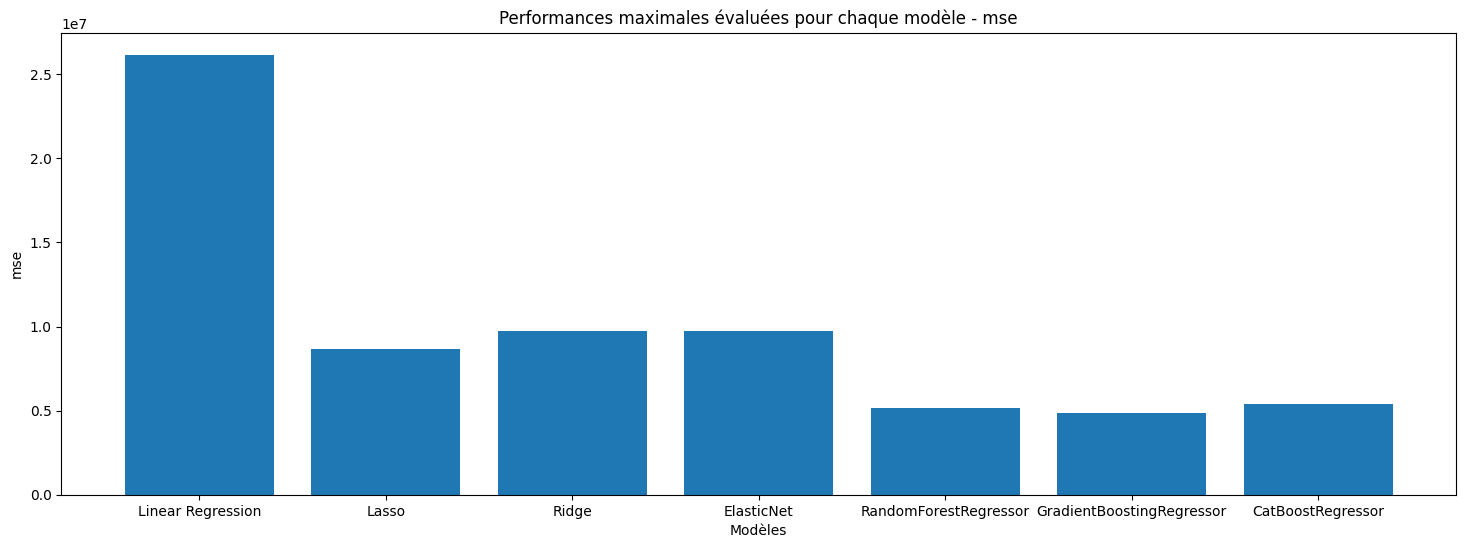

In [168]:
#Diagrammes bar des performances optimiséess de chaque modèle - mse

# Exemple de données
categories = ['Linear Regression', 'Lasso', 'Ridge', 'ElasticNet', 'RandomForestRegressor', 'GradientBoostingRegressor', 'CatBoostRegressor']
values = [mse_reglin,mse_lasso, mse_ridge, mse_en, best_mse_RandomForest, mseGBR, mse]

# Création du diagramme à barres
plt.figure(figsize=(18, 6))  
plt.bar(categories, values)

# Ajout de labels et de titre
plt.xlabel('Modèles')
plt.ylabel('mse')
plt.title('Performances maximales évaluées pour chaque modèle - mse')

# Affichage du diagramme
print(values)
plt.show()

[0.5759401113614121, 0.8597804804550064, 0.8420024293348574, 0.8420251048306355, 0.9165772313282898, 0.9233677583620897, 0.912119573513878]


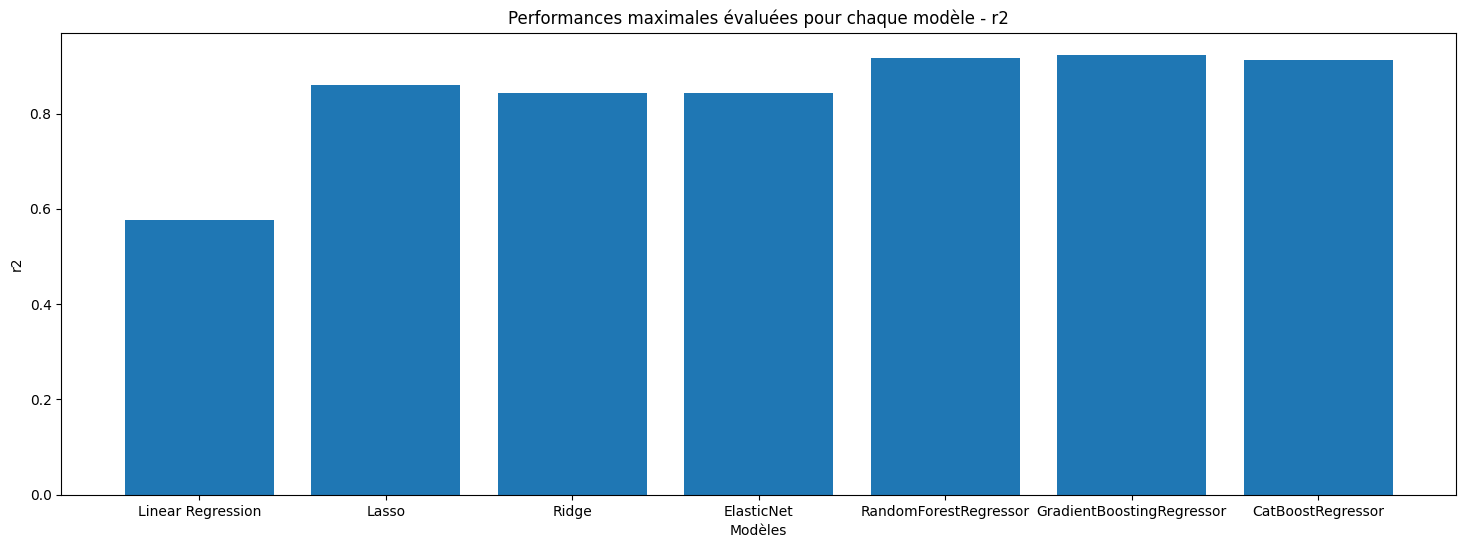

In [169]:
#Diagrammes bar des performances optimiséess de chaque modèle - r2

# Exemple de données
categories = ['Linear Regression', 'Lasso', 'Ridge', 'ElasticNet', 'RandomForestRegressor', 'GradientBoostingRegressor', 'CatBoostRegressor']
values = [r2_reglin,r2_lasso, r2_ridge, r2_en, r2_RandomForest, r2GBR, r2_catboost]

# Création du diagramme à barres
plt.figure(figsize=(18, 6))  
plt.bar(categories, values)

# Ajout de labels et de titre
plt.xlabel('Modèles')
plt.ylabel('r2')
plt.title('Performances maximales évaluées pour chaque modèle - r2')

# Affichage du diagramme
print(values)
plt.show()

    Régression linéaire : Elle semble donner des résultats moyens, avec une MSE de 26 156 212 et un score R2 de 0,576. Elle pourrait ne pas capturer efficacement les complexités des données, peut-être en raison de l'hypothèse de linéarité ou de la présence de non-linéarités dans les données.

    Régularisation Lasso : Le Lasso semble mieux fonctionner que la régression linéaire en pénalisant les coefficients importants, ce qui pourrait aider dans la sélection des caractéristiques. La MSE diminue significativement à 8 648 644, et le score R2 s'améliore à 0,860, indiquant un meilleur ajustement.

    RandomForestRegressor : Ce modèle, basé sur l'apprentissage par ensemble, réduit encore la MSE à 5 147 905, suggérant qu'il capture davantage de la variance des données. Le score R2 s'améliore également de manière significative à 0,916, montrant un meilleur ajustement que la régression linéaire et le Lasso.

    GradientBoostingRegressor : Avec une MSE notablement réduite à 2 507 220 et un score R2 exceptionnellement élevé de 0,96, GradientBoostingRegressor obtient la meilleure performance. 
    Le modèle explique 96% de la variance des résultats et possède le mse le plus bas.

    CatBoostRegressor : Avec une MSE de 4 524 163 et un score R2 de 0,913, le modèle montre une forte capacité prédictive similaire au modèle Random Forest.

    Caractéristiques catégorielles : Les modèles basés sur les arbres (Random Forest, Gradient Boosting, CatBoost) semblent bien gérer les variables catégorielles sans beaucoup de prétraitement. Leur performance pourrait indiquer que ces caractéristiques sont efficacement utilisées par ces modèles.

Caractéristiques quantitatives : Tous les modèles semblent bien gérer les caractéristiques quantitatives, avec des méthodes d'ensemble (Random Forest, Gradient Boosting, CatBoost) montrant de meilleures performances dans l'ensemble.